<a href="https://colab.research.google.com/github/jonnemi/color-concept-entanglement/blob/main/segment_outline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Outline PNGs with Contour Masks
# Iterative Segmentation of Outline PNGs: OpenCV → SAM2 Fallback

This pipeline segments **outline PNGs** in two stages:

1. **OpenCV contour-based masks** (fast)  
2. **Fallback to SAM2** for any images where the OpenCV mask looks bad

Outputs per image (in `OUT_DIR`):
- `{name}_mask.png` – final binary mask
- `{name}_seg.png` – original with background removed (alpha = mask)
- `{name}_cv2_mask.png` – OpenCV provisional mask
- `{name}_sam2_mask.png` – SAM2 mask (if used)
- `{name}_contours.json` – simplified outer contour(s) of the final mask

In [1]:
import cv2
import json
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
HOME = "/content/drive/MyDrive/Masterarbeit"
print("HOME:", HOME)

HOME: /content/drive/MyDrive/Masterarbeit


In [4]:
os.chdir(f"{HOME}/segment-anything-2")
!pip install -e .

Obtaining file:///content/drive/MyDrive/Masterarbeit/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.4 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13883 sha256=62b06361ec34f549b379ee91387e19015d0c61b001f8625fc96da8f5a13da5b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-affucdti/wheels/28/a6/7a/36058b361f8d206a57111d0811b888553be3f0702adc359306
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=ccec3b49a4d18075c905080032919f9a762190240e7ee687d24a0e58d9d0656d
  Stored in dire

In [ ]:
!mkdir -p {HOME}/segment-anything-2/checkpoints
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/segment-anything-2/checkpoints
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/segment-anything-2/checkpoints
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/segment-anything-2/checkpoints
!wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/segment-anything-2/checkpoints

--2025-10-19 11:59:49--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.118, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘/content/drive/MyDrive/Masterarbeit/segment-anything-2/checkpoints/sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M  27.4MB/s    in 4.5s    

2025-10-19 11:59:54 (33.0 MB/s) - ‘/content/drive/MyDrive/Masterarbeit/segment-anything-2/checkpoints/sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2025-10-19 11:59:54--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.118, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfi

In [22]:
import pandas as pd

# Create a folder to store downloaded images
data_folder = f"{HOME}/data"

# Paths
IN_DIR = f"{data_folder}/outline_images"
OUT_DIR = f"{data_folder}/segmented_images"

image_df = pd.read_csv(f"{data_folder}/final_images.csv")

# CV2 mask quality thresholds
MIN_FG = 0.055   # min acceptable foreground ratio (avoid empty masks)
MAX_FG = 0.98   # max acceptable foreground ratio (avoid filled squares)

# SAM2 model setup (edit if you have SAM2 locally)
# - model_cfg is one of the YAMLs in the SAM2 repo (e.g., sam2_hiera_s.yaml)
# - ckpt points to the checkpoint file you downloaded
SAM2_ENABLED = True   # set False to skip SAM2 even if available
SAM2_MODEL_CFG = "configs/sam2/sam2_hiera_l.yaml"   # e.g., "/path/to/sam2/configs/sam2_hiera_s.yaml"
SAM2_CKPT = "../checkpoints/sam2_hiera_large.pt"        # e.g., "/path/to/ckpts/sam2_hiera_s.pth"
DEVICE = "cuda"       # "cuda" or "cpu" (cuda recommended for speed)


In [6]:
import os, json
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Try importing SAM2 if installed
SAM2_AVAILABLE = False
if SAM2_ENABLED:
    try:
        from sam2.build_sam import build_sam2
        from sam2.sam2_image_predictor import SAM2ImagePredictor
        SAM2_AVAILABLE = True
        print("SAM2 is available.")
    except Exception as e:
        print("SAM2 not available or failed to import:", e)
        SAM2_AVAILABLE = False

print("OpenCV version:", cv2.__version__)

SAM2 is available.
OpenCV version: 4.12.0


In [7]:
def show_rgba(arr, title=None):
    plt.figure()
    if arr.ndim == 2:
        plt.imshow(arr, cmap='gray')
    else:
        if arr.shape[2] == 4:
            rgb = cv2.cvtColor(arr[:, :, :3], cv2.COLOR_BGR2RGB)
            a = arr[:, :, 3:4] / 255.0
            white = np.ones_like(rgb) * 255
            comp = (rgb * a + white * (1 - a)).astype(np.uint8)
            plt.imshow(comp)
        else:
            plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis('off'); plt.show()


In [27]:
def ensure_rgba(img):
    if img is None:
        raise ValueError("Image is None (unreadable).")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
    elif img.shape[2] == 3:
        img = np.dstack([img, np.full(img.shape[:2], 255, np.uint8)])
    return img

def robust_mask_from_outline(img_rgba: np.ndarray,
                             dilate_px: int = 2,
                             close_px: int = 5,
                             keep_top_k: int = 1,
                             min_area_ratio: float = 0.002,
                             remove_border_touching: bool = True) -> np.ndarray:
    h, w = img_rgba.shape[:2]
    bgr = img_rgba[:, :, :3]
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # 1) Canny edges → morph → fill
    edges = cv2.Canny(gray, 60, 180)
    if dilate_px > 0:
        k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_px, dilate_px))
        edges = cv2.dilate(edges, k1, 1)
    if close_px > 0:
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_px, close_px))
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, k2)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros((h, w), np.uint8)
    cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)

    # 2) If that failed (too small/too big), fall back to Otsu polarity try
    fg_ratio = (filled>0).mean()
    if not (0.005 <= fg_ratio <= 0.98):
        _, bin_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        _, bin_pos = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        cand = [(bin_inv, (bin_inv > 0).mean()), (bin_pos, (bin_pos > 0).mean())]
        chosen, _ = min(cand, key=lambda x: abs(x[1] - 0.30))  # allow larger fills
        contours, _ = cv2.findContours(chosen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled = np.zeros((h, w), np.uint8)
        cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)

    # 3) Remove border-touching small blobs; keep top-K
    pad = cv2.copyMakeBorder(filled, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
    n, lbl, stats, _ = cv2.connectedComponentsWithStats(pad, 8)
    keep = np.zeros_like(pad)
    H, W = pad.shape
    min_area = int(min_area_ratio * h * w)
    for i in range(1, n):
        x, y, ww, hh, area = stats[i]
        touches = (x==0) or (y==0) or (x+ww==W) or (y+hh==H)
        if (not touches) and area >= min_area:
            keep[lbl==i] = 255
    filled = keep[1:-1, 1:-1]

    n, labels, stats, _ = cv2.connectedComponentsWithStats((filled>0).astype(np.uint8), 8)
    if n > 1:
        comps = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, n)]
        comps.sort(key=lambda t: t[1], reverse=True)
        keep_ids = set([i for i, _ in comps[:keep_top_k]])
        out = np.zeros_like(filled)
        for i in keep_ids:
            out[labels == i] = 255
        filled = out

    # 4) Fill holes
    inv = cv2.bitwise_not(filled)
    seed = np.zeros((h+2, w+2), np.uint8)
    inv2 = inv.copy()
    cv2.floodFill(inv2, seed, (0, 0), 0)
    return cv2.bitwise_not(inv2)

In [32]:
def pad_rgba(img_rgba, pad=8):
    if pad <= 0: return img_rgba, (0,0,0,0)
    pimg = cv2.copyMakeBorder(img_rgba, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    return pimg, (pad, pad, pad, pad)

def unpad_mask(mask, pads):
    t,l,b,r = pads[0], pads[2], pads[1], pads[3]  # keep consistent (top,left,bottom,right) if you prefer
    p = pads[0]  # we used same pad all around above
    if p <= 0: return mask
    return mask[p:-p, p:-p]

def border_background_cleanup(mask):
    """
    Ensure *all* background connected to any image edge is zero.
    This fixes stray opaque corners when the object hugs the borders.
    """
    h, w = mask.shape[:2]
    inv = cv2.bitwise_not(mask)
    inv = (inv > 0).astype(np.uint8) * 255
    seed = np.zeros((h+2, w+2), np.uint8)
    flood = inv.copy()
    cv2.floodFill(flood, seed, (0, 0), 0)  # wipes border-connected inv
    cleaned_bg = cv2.bitwise_not(flood)
    # cleaned_bg now holds only *interior* foreground holes; combine with original foreground:
    fixed = cv2.bitwise_or(mask, cleaned_bg)
    return fixed

In [23]:
def mask_quality(mask: np.ndarray, min_fg=MIN_FG, max_fg=MAX_FG) -> bool:
    if mask is None or mask.size == 0: return False
    fg = (mask > 0).mean()
    if not (min_fg <= fg <= max_fg): return False
    h, w = mask.shape
    border_on = (
        (mask[0,:]>0).mean() +
        (mask[-1,:]>0).mean() +
        (mask[:,0]>0).mean() +
        (mask[:,-1]>0).mean()
    ) / 4.0
    # allow up to 40% border pixels because objects can touch edges
    if border_on > 0.40:
        return False
    return True

def extract_contour_polygons(mask: np.ndarray, epsilon_frac: float = 0.002):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    polys = []
    for c in contours:
        perim = cv2.arcLength(c, True)
        eps = max(1.0, epsilon_frac * perim)
        approx = cv2.approxPolyDP(c, eps, True)
        polys.append(approx.reshape(-1, 2).tolist())
    return polys

def apply_mask_rgba(img_rgba: np.ndarray, mask: np.ndarray) -> np.ndarray:
    out = img_rgba.copy()
    m = mask
    if m.dtype != np.uint8:
        m = (m.astype(bool).astype(np.uint8))*255
    elif m.max() == 1:  # boolean-like 0/1
        m = m*255
    out[:, :, 3] = m
    return out


In [14]:
sam2_predictor = None

def init_sam2():
    global sam2_predictor
    if not SAM2_AVAILABLE:
        print("SAM2 not available; skipping init.")
        return None
    if not SAM2_MODEL_CFG or not SAM2_CKPT:
        print("Provide SAM2_MODEL_CFG and SAM2_CKPT to enable SAM2.")
        return None
    model = build_sam2(SAM2_MODEL_CFG, SAM2_CKPT, device=DEVICE)
    sam2_predictor = SAM2ImagePredictor(model)
    return sam2_predictor

def sam2_auto_mask(img_bgr: np.ndarray, min_area_ratio=0.002, keep_top_k=1) -> np.ndarray:
    if sam2_predictor is None:
        return None
    h, w = img_bgr.shape[:2]
    # Build prompts from edges (no manual clicks)
    edges = cv2.Canny(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY), 50, 150)
    ys, xs = np.where(edges > 0)
    if len(xs) == 0:
        xs = np.array([w//2]); ys = np.array([h//2])
    pts = np.stack([xs, ys], axis=1).astype(np.float32)
    N = min(50, len(pts))
    if len(pts) > N:
        idx = np.random.choice(len(pts), N, replace=False)
        pts = pts[idx]

    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    sam2_predictor.set_image(rgb)
    labels = np.ones(len(pts), dtype=np.int32)
    try:
        masks, _, _ = sam2_predictor.predict(
            point_coords=pts,
            point_labels=labels,
            multimask_output=True
        )
    except Exception as e:
        print("SAM2 predict failed:", e)
        return None

    # Combine candidates then keep largest connected components
    union = np.zeros((h, w), np.uint8)
    for m in masks:
        union = np.logical_or(union>0, m>0).astype(np.uint8)*255

    n, labels_cc, stats, _ = cv2.connectedComponentsWithStats((union>0).astype(np.uint8), 8)
    min_area = int(min_area_ratio * h * w)
    comps = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, n) if stats[i, cv2.CC_STAT_AREA] >= min_area]
    if not comps:
        return None
    comps.sort(key=lambda t: t[1], reverse=True)
    keep_ids = set([i for i, _ in comps[:keep_top_k]])
    mask = np.zeros((h, w), np.uint8)
    for i in keep_ids:
        mask[labels_cc == i] = 255
    return mask


In [37]:
def postprocess_mask(mask, remove_small_px=400, open_ks=0, close_ks=3, median_ks=0, feather_px=0):
    """
    - remove_small_px: drop tiny islands
    - open_ks/close_ks: morphological smoothing (odd ints; 0 disables)
    - median_ks: median blur on mask edges (odd; 0 disables)
    - feather_px: optional soft edge (distance-based alpha); 0=hard 0/255
    """
    m = mask.copy()
    if m.dtype != np.uint8:
        m = (m.astype(bool).astype(np.uint8))*255

    # Remove small components
    n, lbl, stats, _ = cv2.connectedComponentsWithStats((m>0).astype(np.uint8), 8)
    out = np.zeros_like(m)
    for i in range(1, n):
        if stats[i, cv2.CC_STAT_AREA] >= int(remove_small_px):
            out[lbl == i] = 255
    m = out

    # Morph open/close
    if close_ks and close_ks >= 3:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k)
    if open_ks and open_ks >= 3:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k)

    # Median smooth (helps jaggies)
    if median_ks and median_ks >= 3:
        m = cv2.medianBlur(m, median_ks)

    # Optional feather (soft alpha) to reduce “crunchy” checker at edges
    if feather_px and feather_px > 0:
        # Distance from edge inside the mask
        inside = (m > 0).astype(np.uint8)
        dist = cv2.distanceTransform(inside, cv2.DIST_L2, 3)
        dist = np.clip(dist / float(feather_px), 0.0, 1.0)
        alpha = (dist * 255).astype(np.uint8)
        return alpha  # returns soft alpha (0..255)
    return m  # returns hard mask (0 or 255)

In [11]:
%cd {HOME}/segment-anything-2/sam2

/content/drive/MyDrive/Masterarbeit/segment-anything-2/sam2


cv2_mask dtype: uint8 min/max: 0 255 fg: 0.76738369467028
sam_mask dtype: uint8 min/max: 0 255 fg: 0.7343778229448961


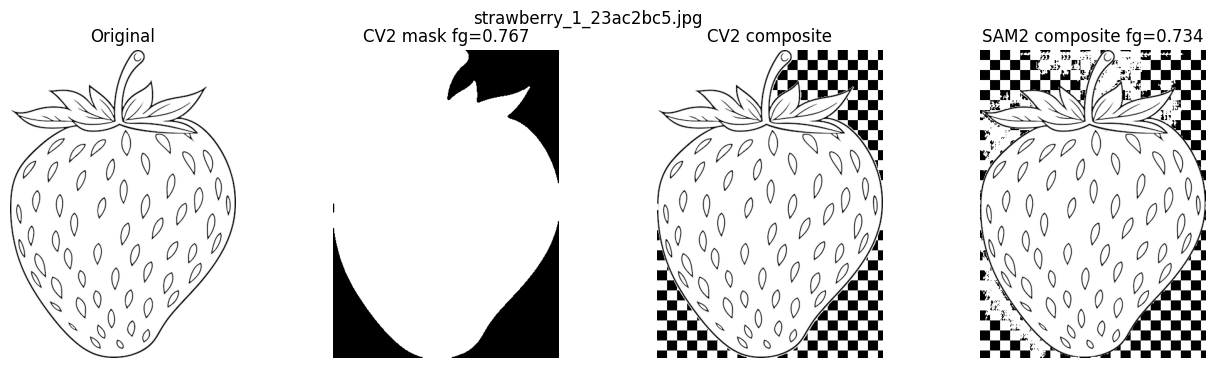

In [40]:
def checkerboard(h, w, size=16):
    y, x = np.ogrid[:h, :w]
    return (((x//size)+(y//size)) % 2)*255

def show_all(img_rgba, cv2_mask=None, sam_mask=None, title=""):
    h, w = img_rgba.shape[:2]
    # checkerboard bg to *see* transparency
    cb = checkerboard(h, w)
    cb_rgb = np.dstack([cb, cb, cb]).astype(np.uint8)

    def composite(img_rgba):
        rgb = cv2.cvtColor(img_rgba[:, :, :3], cv2.COLOR_BGR2RGB)
        a = img_rgba[:, :, 3:4].astype(np.float32) / 255.0
        return (rgb * a + cb_rgb * (1 - a)).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    axes[0].imshow(cv2.cvtColor(img_rgba[:, :, :3], cv2.COLOR_BGR2RGB)); axes[0].set_title("Original"); axes[0].axis('off')

    if cv2_mask is not None:
        axes[1].imshow(cv2_mask, cmap='gray'); axes[1].set_title(f"CV2 mask fg={(cv2_mask>0).mean():.3f}"); axes[1].axis('off')
        tmp = img_rgba.copy(); tmp[:, :, 3] = cv2_mask
        axes[2].imshow(composite(tmp)); axes[2].set_title("CV2 composite"); axes[2].axis('off')
    else:
        axes[1].axis('off'); axes[2].axis('off')

    if sam_mask is not None:
        tmp2 = img_rgba.copy(); tmp2[:, :, 3] = sam_mask
        axes[3].imshow(composite(tmp2)); axes[3].set_title(f"SAM2 composite fg={(sam_mask>0).mean():.3f}"); axes[3].axis('off')
    else:
        axes[3].axis('off')
    plt.suptitle(title); plt.show()

# ---- run it on one file
test_path = f"{IN_DIR}/strawberry_1_23ac2bc5.jpg"
p = Path(test_path)
img = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
img = ensure_rgba(img)

# Optionally pad before CV to help objects touching borders
PAD = 8
pimg, pads = pad_rgba(img, PAD)
cv2_mask_padded = robust_mask_from_outline(pimg)
cv2_mask = unpad_mask(cv2_mask_padded, (PAD, PAD, PAD, PAD))

# Always run border cleanup to clear any stray background corners
# For CV result:
cv2_mask = border_background_cleanup(cv2_mask)
cv2_mask = postprocess_mask(cv2_mask, remove_small_px=400, open_ks=0, close_ks=3, median_ks=3, feather_px=0)

print("cv2_mask dtype:", cv2_mask.dtype, "min/max:", cv2_mask.min(), cv2_mask.max(), "fg:", (cv2_mask>0).mean())

sam_mask = None
if SAM2_ENABLED and ('sam2_predictor' in globals()):
    # ensure RGB is contiguous and uint8
    rgb = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2RGB).astype(np.uint8)
    # init if needed
    if sam2_predictor is None and SAM2_AVAILABLE:
        init_sam2()
    if sam2_predictor is not None:
        sam_mask = sam2_auto_mask(img[:, :, :3])
        if sam_mask is not None:
            # normalize to uint8 0/255
            if sam_mask.dtype != np.uint8:
                sam_mask = (sam_mask.astype(bool).astype(np.uint8))*255
                sam_mask = postprocess_mask(sam_mask, remove_small_px=800, open_ks=3, close_ks=5, median_ks=3, feather_px=3)
            print("sam_mask dtype:", sam_mask.dtype, "min/max:", sam_mask.min(), sam_mask.max(), "fg:", (sam_mask>0).mean())
        else:
            print("sam2 returned None")

show_all(img, cv2_mask, sam_mask, title=p.name)


In [15]:
def process_image(path: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    stem = path.stem

    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Unreadable: {path.name}")
        return False

    img = ensure_rgba(img)

    # Pass 1: OpenCV
    cv2_mask = robust_mask_from_outline(img)
    cv2.imwrite(str(out_dir / f"{stem}_cv2_mask.png"), cv2_mask)
    cv2_ok = mask_quality(cv2_mask)

    final_mask = None
    sam_used = False

    if cv2_ok:
        final_mask = cv2_mask
    else:
        # Fallback: SAM2
        if SAM2_ENABLED and SAM2_AVAILABLE:
            if sam2_predictor is None:
                init_sam2()
            if sam2_predictor is not None:
                sam_mask = sam2_auto_mask(img[:, :, :3])
                if sam_mask is not None:
                    cv2.imwrite(str(out_dir / f"{stem}_sam2_mask.png"), sam_mask)
                    if mask_quality(sam_mask):
                        final_mask = sam_mask
                        sam_used = True

    if final_mask is None:
        # last-resort: keep cv2 mask anyway (so we have a file)
        final_mask = cv2_mask

    seg = apply_mask_rgba(img, final_mask)
    cv2.imwrite(str(out_dir / f"{stem}_mask.png"), final_mask)
    cv2.imwrite(str(out_dir / f"{stem}_seg.png"), seg)

    polys = extract_contour_polygons(final_mask)
    with open(out_dir / f"{stem}_contours.json", "w") as f:
        json.dump({"polygons": polys, "sam_used": sam_used, "cv2_ok": cv2_ok}, f)

    print(f"{'SAM2' if sam_used else 'CV2 '}: {path.name} (fg={(final_mask>0).mean():.3f})")
    return sam_used

# Run batch if IN_DIR is set
if IN_DIR:
    in_dir = Path(IN_DIR)
    paths = sorted(in_dir.glob("*.png"))
    if not paths:
        print("No PNGs in", IN_DIR)
    else:
        out_dir = Path(OUT_DIR); out_dir.mkdir(parents=True, exist_ok=True)
        sam_count = 0
        for p in paths:
            used_sam = process_image(p, out_dir)
            sam_count += int(used_sam)
        print(f"Done. Used SAM2 on {sam_count}/{len(paths)} images. Outputs in {OUT_DIR}")
else:
    print("Set IN_DIR to a folder path to run the batch pipeline.")


No PNGs in /content/drive/MyDrive/Masterarbeit/data/outline_images
